# Analysis of AirBnb data
* I used the data from [InsideAirbnb](http://insideairbnb.com/paris/#) to provide the data here - we picked Paris as a good example.
* The aim is to produce a few models of this phenomenoa.

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy as sp
import pymc3 as pm3
from scipy import stats
from IPython.core.pylabtools import figsize
import os
figsize(12, 12)
sns.set_style('darkgrid')

In [13]:

def p2f(x):
    return float(x.strip('%'))/100

In [55]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gzip
import shutil
import matplotlib.font_manager as font_manager

"""Unzip the gz file"""

with gzip.open('listings.csv.gz', 'rb') as f_in:
    with open('listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

"""Reading CSV file. Th etotal number of rows in listing is 44666"""

pd.set_option('precision', 4)
df_listing = pd.read_csv('listings.csv')

df_listing.shape

(44666, 74)

In [56]:
"""Remove unwanted chracters from price. Convert price to float. Select properties with price more than 0"""

df_listing['price'] = df_listing['price'].str.replace('$', '')
df_listing['price'] = df_listing['price'].str.replace(',', '')
df_listing["price"] = pd.to_numeric(df_listing["price"], downcast="float")
df_listing = df_listing[df_listing.price > 0]

df_listing.isnull().sum().sort_values(ascending=False)

bathrooms                       44641
license                         44641
calendar_updated                44641
host_response_time              23068
host_response_rate              23068
                                ...  
property_type                       0
longitude                           0
latitude                            0
neighbourhood_group_cleansed        0
id                                  0
Length: 74, dtype: int64

In [57]:
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [58]:
df_to_model = df_listing[['reviews_per_month', 'number_of_reviews', 'host_response_rate', 'instant_bookable', 'review_scores_communication', 'price']]

In [59]:
df_to_model

,reviews_per_month,number_of_reviews,host_response_rate,instant_bookable,review_scores_communication,price
0,0.36,48,70%,f,10.0,175.0
1,4.82,354,98%,f,9.0,76.0
2,0.36,50,NaN,f,10.0,60.0
3,0.01,1,100%,f,10.0,175.0
4,3.40,473,100%,f,9.0,73.0
...,...,...,...,...,...,...
44661,NaN,0,100%,f,NaN,50.0
44662,NaN,0,100%,f,NaN,200.0
44663,NaN,0,100%,f,NaN,92.0
44664,NaN,0,100%,f,NaN,120.0


In [60]:
df_to_model['reviews_per_month'] = df_to_model['reviews_per_month'].fillna(0)
df_to_model['host_response_rate'] = df_to_model['host_response_rate'].fillna(0)
df_to_model['review_scores_communication'] = df_to_model['review_scores_communication'].fillna(0)
df_to_model['instant_bookable'] = df_to_model['instant_bookable'].astype('category')
df_to_model['reviews_per_month'] = df_to_model['reviews_per_month'].astype('int32')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [61]:
df_to_model['host_response_rate'] = df_to_model['host_response_rate'].astype('str')
df_to_model['host_response_rate'] = df_to_model['host_response_rate'].apply(p2f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
df_to_model

,reviews_per_month,number_of_reviews,host_response_rate,instant_bookable,review_scores_communication,price
0,0,48,0.70,f,10.0,175.0
1,4,354,0.98,f,9.0,76.0
2,0,50,0.00,f,10.0,60.0
3,0,1,1.00,f,10.0,175.0
4,3,473,1.00,f,9.0,73.0
...,...,...,...,...,...,...
44661,0,0,1.00,f,0.0,50.0
44662,0,0,1.00,f,0.0,200.0
44663,0,0,1.00,f,0.0,92.0
44664,0,0,1.00,f,0.0,120.0


In [63]:
y = df_listing['price'].values
df_to_model

,reviews_per_month,number_of_reviews,host_response_rate,instant_bookable,review_scores_communication,price
0,0,48,0.70,f,10.0,175.0
1,4,354,0.98,f,9.0,76.0
2,0,50,0.00,f,10.0,60.0
3,0,1,1.00,f,10.0,175.0
4,3,473,1.00,f,9.0,73.0
...,...,...,...,...,...,...
44661,0,0,1.00,f,0.0,50.0
44662,0,0,1.00,f,0.0,200.0
44663,0,0,1.00,f,0.0,92.0
44664,0,0,1.00,f,0.0,120.0


In [64]:
df_to_model = pd.get_dummies(df_to_model)

In [65]:
X = df_to_model.values

* Let us look at one of the columns. 
* We see below that we have a very large variety of numbers, let us apply next a preprocessing step. 

In [66]:
X[:,1]

array([ 48., 354.,  50., ...,   0.,   0.,   0.])

In [67]:
from sklearn import preprocessing
X[:,1] = preprocessing.scale(X[:,1])


In [21]:
X

array([[ 0.        ,  0.54738112,  0.7       , 10.        ,  1.        ,
         0.        ],
       [ 4.        ,  7.10489471,  0.98      ,  9.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.59024069,  0.        , 10.        ,  1.        ,
         0.        ],
       ...,
       [ 0.        , -0.48124846,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        , -0.48124846,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        , -0.48124846,  1.        ,  0.        ,  1.        ,
         0.        ]])

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
names = df_to_model.columns.tolist()

In [ ]:
X_train

array([[ 0.        , -0.47794405,  0.3       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.43362274,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        , -0.52226535,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        , -0.47794405,  0.1       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.43362274,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.        ,  0.36416083,  0.97      , ...,  0.        ,
         0.        ,  0.        ]])

In [70]:
features = df_to_model.columns
features = np.asarray(features)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 1.000000
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 1.000000


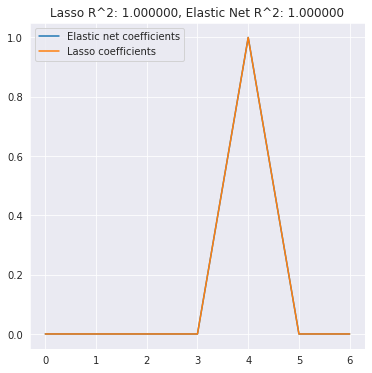

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
figsize(6,6)
alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

###############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, label='Elastic net coefficients')
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn import ensemble
###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 17, 'max_features': 1.0,
          'learning_rate': 0.01, 'loss': 'huber'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')



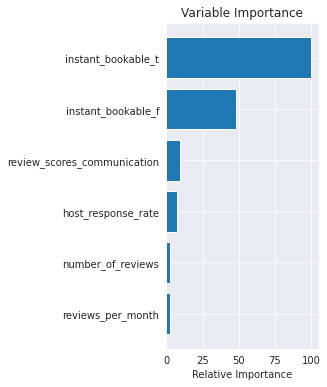

In [34]:
###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, names)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 16722.7329
